In [1]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
from qiskit import Aer
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.insert(0, '../../src/')
from neuralnetwork import *
from analysis import *
from utils import *

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Expressivity of QKN vs Classic NN

## Trajectory Length

In [2]:
theta = np.linspace(0, 2*np.pi, 1000)
theta = np.append(theta, theta[0:1]).reshape(-1,1)

x = np.pi*(np.cos(theta) + 1)/2
y = np.pi*(np.sin(theta) + 1)/2
x_qcn = np.hstack([x, y])
print(x_qcn.shape)
x_dnn = scaler(x_qcn, mode="standard")

(1001, 2)


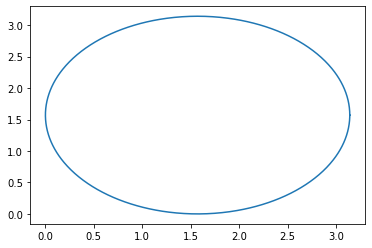

In [3]:
plt.plot(x_qcn[:,0], x_qcn[:,1])
plt.show()

## Random Initialization

### QCN

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[4],
                         dim = [2] + 7*[4],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_4_reps_2"))

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[5],
                         dim = [2] + 7*[5],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_5_reps_2"))

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[6],
                         dim = [2] + 7*[6],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_6_reps_2"))

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[7],
                         dim = [2] + 7*[7],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_7_reps_2"))

In [ ]:
np.random.seed(42)

network = sequential_qnn(n_qubits = 8*[8],
                         dim = [2] + 7*[8],
                         scale = 8*[[-np.pi, np.pi]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)

tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_width_8_reps_2"))

### DNN

In [ ]:
network = sequential_dnn(dim=[2] + 7*[10])

tl = TrajectoryLength(network)
tl.fit(x_dnn)

network.predict(x_dnn, verbose=True)
saver(tl, data_path("tl_expressivity_dnn"))

## Training

In [4]:
np.random.seed(42)

n = 10
x = np.linspace(0, 1, n)
x = generate_meshgrid([x,x])

mean1 = np.array([[0.25, 0.75]])
var1 = np.array([[0.02, 0], [0, 0.02]])

mean2 = np.array([[0.75, 0.25]])
var2 = np.array([[0.02, 0], [0, 0.02]])

mean3 = np.array([[0.25, 0.25]])
var3 = np.array([[0.02, 0], [0, 0.02]])

mean4 = np.array([[0.75, 0.75]])
var4 = np.array([[0.02, 0], [0, 0.02]])

y = gaussian(x, mean1, var1) + gaussian(x, mean2, var2) - gaussian(x, mean3, var3) - gaussian(x, mean4, var4)


x_train_qnn = scaler(x, a=-np.pi/2, b=np.pi/2)
x_train_dnn = scaler(x, mode="standard")
y = scaler(y, a=0, b=1)
print(y.shape)

(100, 1)


### QCN

In [ ]:
np.random.seed(42)
network = sequential_qnn(n_qubits = [5, 5, 5, 5],
                         dim = [2, 5, 5, 5, 1] ,
                         scale = 3*[[-np.pi, np.pi]] + [[0,1]],
                         encoder = Encoder(mode="x"),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0,
                         optimizer=Adam(lr=0.1))

In [ ]:
tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_epochs_0"))

In [ ]:
network.train(x_train_qnn, y, epochs = 10, verbose=True)

In [ ]:
tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_epochs_10"))

In [ ]:
network.train(x_train_qnn, y, epochs = 10, verbose=True)

In [ ]:
tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_epochs_20"))

In [ ]:
network.train(x_train_qnn, y, epochs = 10, verbose=True)

In [ ]:
tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_epochs_30"))

In [ ]:
network.train(x_train_qnn, y, epochs = 10, verbose=True)

In [ ]:
tl = TrajectoryLength(network)
tl.fit(x_qcn)
saver(tl, data_path("tl_expressivity_epochs_40"))

### DNN

In [5]:
np.random.seed(42)
network = sequential_dnn(dim=[2, 8, 8, 8, 1],
                         optimizer=Adam(lr=0.1))

In [6]:
tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_0_dnn"))

In [7]:
network.train(x_train_dnn, y, epochs=37, verbose=True)

  0%|          | 0/37 [00:00<?, ?it/s]

epoch: 0, loss: 0.053186194617715746
epoch: 1, loss: 0.06199133622229081
epoch: 2, loss: 0.05322642532934586
epoch: 3, loss: 0.050674831623350756
epoch: 4, loss: 0.05401105050340627
epoch: 5, loss: 0.054195186009064915
epoch: 6, loss: 0.05185497659673876
epoch: 7, loss: 0.05040158013895526
epoch: 8, loss: 0.05071056177397753
epoch: 9, loss: 0.051647175983572435
epoch: 10, loss: 0.052101267661602044
epoch: 11, loss: 0.051819871473773996
epoch: 12, loss: 0.05114138549426521
epoch: 13, loss: 0.05052173644402245
epoch: 14, loss: 0.05024711038890553
epoch: 15, loss: 0.050340588438744074
epoch: 16, loss: 0.05059747171372582
epoch: 17, loss: 0.050741357683093014
epoch: 18, loss: 0.05062626041434968
epoch: 19, loss: 0.0503106665501665
epoch: 20, loss: 0.04995688040426301
epoch: 21, loss: 0.0496874545347483
epoch: 22, loss: 0.04951909167151136
epoch: 23, loss: 0.0493845332099185
epoch: 24, loss: 0.049189171544573786
epoch: 25, loss: 0.048859077511564576
epoch: 26, loss: 0.04836923128660381
epoc

In [8]:
tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_37_dnn"))

In [9]:
network.train(x_train_dnn, y, epochs=51, verbose=True)

  0%|          | 0/51 [00:00<?, ?it/s]

epoch: 0, loss: 0.032729039893207364
epoch: 1, loss: 0.029881662130932667
epoch: 2, loss: 0.027432469286786828
epoch: 3, loss: 0.02486982299976971
epoch: 4, loss: 0.022651249258957628
epoch: 5, loss: 0.02095799813052056
epoch: 6, loss: 0.01938705529144624
epoch: 7, loss: 0.01795053307236266
epoch: 8, loss: 0.016898355740301435
epoch: 9, loss: 0.015964227468138654
epoch: 10, loss: 0.014917572075817585
epoch: 11, loss: 0.014085997925997414
epoch: 12, loss: 0.013594604695485539
epoch: 13, loss: 0.013129662408418
epoch: 14, loss: 0.012734845579612322
epoch: 15, loss: 0.012631789866781429
epoch: 16, loss: 0.012618295967364308
epoch: 17, loss: 0.012649533689755871
epoch: 18, loss: 0.012736870483533325
epoch: 19, loss: 0.012661301258019423
epoch: 20, loss: 0.012607999115140898
epoch: 21, loss: 0.012659044243681502
epoch: 22, loss: 0.01262427404052554
epoch: 23, loss: 0.012559101353623174
epoch: 24, loss: 0.012438615691063195
epoch: 25, loss: 0.012299870569091233
epoch: 26, loss: 0.01226474799

In [10]:
tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_88_dnn"))

In [11]:
network.train(x_train_dnn, y, epochs=33, verbose=True)

  0%|          | 0/33 [00:00<?, ?it/s]

epoch: 0, loss: 0.008217649895576617
epoch: 1, loss: 0.008080776619736144
epoch: 2, loss: 0.0079693667240942
epoch: 3, loss: 0.007856707888340881
epoch: 4, loss: 0.0077416066676496195
epoch: 5, loss: 0.007629294547868699
epoch: 6, loss: 0.0075018283941939755
epoch: 7, loss: 0.007388082423918293
epoch: 8, loss: 0.007353900524226913
epoch: 9, loss: 0.0077994089408755345
epoch: 10, loss: 0.008243475155509777
epoch: 11, loss: 0.007044325874879537
epoch: 12, loss: 0.007333692687576684
epoch: 13, loss: 0.00730205026804965
epoch: 14, loss: 0.006641332779098768
epoch: 15, loss: 0.007125812992671114
epoch: 16, loss: 0.006362686449767473
epoch: 17, loss: 0.006724535502446379
epoch: 18, loss: 0.006161860322032562
epoch: 19, loss: 0.006322471262142411
epoch: 20, loss: 0.0059551233297041005
epoch: 21, loss: 0.005895086583493373
epoch: 22, loss: 0.005720675322148202
epoch: 23, loss: 0.005491351532694583
epoch: 24, loss: 0.005451592783155358
epoch: 25, loss: 0.005123760143638328
epoch: 26, loss: 0.00

In [12]:
tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_121_dnn"))

In [13]:
network.train(x_train_dnn, y, epochs=39, verbose=True)

  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 0, loss: 0.003809565110212449
epoch: 1, loss: 0.003671124286091385
epoch: 2, loss: 0.0035126530827247985
epoch: 3, loss: 0.003342200856111838
epoch: 4, loss: 0.003242600343962645
epoch: 5, loss: 0.003065185714292144
epoch: 6, loss: 0.003000730136264862
epoch: 7, loss: 0.0028389869047579096
epoch: 8, loss: 0.002777289659079728
epoch: 9, loss: 0.0026589728073105807
epoch: 10, loss: 0.00257270363155521
epoch: 11, loss: 0.0025072658487167165
epoch: 12, loss: 0.002400559099386522
epoch: 13, loss: 0.0023594057098356163
epoch: 14, loss: 0.002270602422147458
epoch: 15, loss: 0.002214110556360824
epoch: 16, loss: 0.002165484982088098
epoch: 17, loss: 0.0020909099560134465
epoch: 18, loss: 0.0020558050712135207
epoch: 19, loss: 0.0019991744008838962
epoch: 20, loss: 0.0019465980380429055
epoch: 21, loss: 0.0019160295076916362
epoch: 22, loss: 0.0018630381727186417
epoch: 23, loss: 0.0018261662411104313
epoch: 24, loss: 0.001795569498033667
epoch: 25, loss: 0.0017497782552384686
epoch: 26,

In [14]:
tl = TrajectoryLength(network)
tl.fit(x_dnn)
saver(tl, data_path("tl_expressivity_epochs_160_dnn"))